#Stanford Dog's Classification
This Project is done using Google Colaboratory.
1st you have to mount google drive with Colab and place dataset in zipped format on Google drive to access it.
I have first resized all the images in the dataset to 256*256 and then uploaded on drive. it contains 12000 training images of 120 classes of Dogs and 8588 test images.
Top-1 Accuracy i have achieved is 76.66 % on Test set.
Top-5 Accuracy is 96.15% on Test set. 

In [0]:
!unzip drive/Dogs.zip    # this line copies the dogs dataset from Google drive to Google Colab and also Unzip it for further processing. 

Next cell is for installation of PyTorch and OpenCV on Google Colab

In [0]:
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision

In [0]:
# here are the necessary imports
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion()   

# **Load Data**
We will use torchvision and torch.utils.data packages for loading the data.

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'Training': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Testing': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'Dogs'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Training', 'Testing']}
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['Training', 'Testing']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Testing']}
class_names = image_datasets['Training'].classes

use_gpu = torch.cuda.is_available()

# Visualize a few images 
Let's visualize a few training images so as to understand the data augmentations.

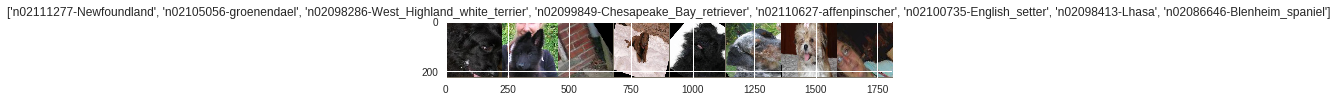

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloders['Training']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#Training the model
Now, let's write a general function to train a model.

In [0]:
def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Training', 'Testing']:
            if phase == 'Training':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'Training':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Testing' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                state = {'model':model_ft.state_dict(),'optim':optimizer_ft.state_dict()}
                torch.save(state,'drive/point_resnet_best_dogs.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

#Visualizing the model predictions

Generic function to display predictions for a few images

In [0]:
def visualize_model(model, num_images=8):
    images_so_far = 0
    fig = plt.figure()
    

    for i, data in enumerate(dataloders['Testing']):
        inputs, labels = data
        #print(labels)
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        #print(labels)
        #_, lab = torch.max(labels.data, 1)
        outputs = model(inputs)
        #print(outputs)
        _, preds = torch.max(outputs.data, 1)
        #print(preds)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

#Finetuning the convnet
Load a pretrained Resnet 18 model and reset final fully connected layer.

In [0]:
model_ft = models.resnet18(pretrained=True) # loading a pre-trained(trained on image net) resnet18 model from torchvision models
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 120)

if use_gpu:
    model_ft = model_ft.cuda()
#model_ft = model_ft.float()
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

You can load a checkpoint from your my drive or any other place if you have saved it. you have to load weights of model and optimizer

In [0]:
#checkpoint = torch.load('path to model')
checkpoint = torch.load('drive/point_resnet_best_dogs.pth')
model_ft.load_state_dict(checkpoint['model'])
optimizer_ft.load_state_dict(checkpoint['optim'])

#Train and evaluate

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft,num_epochs=20)

Epoch 0/19
----------
Training Loss: 0.1704 Acc: 0.6375
Testing Loss: 0.0970 Acc: 0.7587

Epoch 1/19
----------
Training Loss: 0.1707 Acc: 0.6392
Testing Loss: 0.0976 Acc: 0.7632

Epoch 2/19
----------
Training Loss: 0.1694 Acc: 0.6464
Testing Loss: 0.1003 Acc: 0.7522

Epoch 3/19
----------
Training Loss: 0.1669 Acc: 0.6450
Testing Loss: 0.0973 Acc: 0.7620

Epoch 4/19
----------
Training Loss: 0.1670 Acc: 0.6451
Testing Loss: 0.0967 Acc: 0.7606

Epoch 5/19
----------
Training Loss: 0.1641 Acc: 0.6492
Testing Loss: 0.0977 Acc: 0.7594

Epoch 6/19
----------
Training Loss: 0.1609 Acc: 0.6622
Testing Loss: 0.0985 Acc: 0.7557

Epoch 7/19
----------
Training Loss: 0.1626 Acc: 0.6587
Testing Loss: 0.1000 Acc: 0.7568

Epoch 8/19
----------
Training Loss: 0.1598 Acc: 0.6613
Testing Loss: 0.0984 Acc: 0.7582

Epoch 9/19
----------
Training Loss: 0.1591 Acc: 0.6604
Testing Loss: 0.1007 Acc: 0.7516

Epoch 10/19
----------
Training Loss: 0.1585 Acc: 0.6610
Testing Loss: 0.1005 Acc: 0.7529

Epoch 11/

# Saving a checkpoint

In [0]:
state = {'model':model_ft.state_dict(),'optim':optimizer_ft.state_dict()}
torch.save(state,'drive/point_resnet_best.pth')

# Checking Model's Predictions

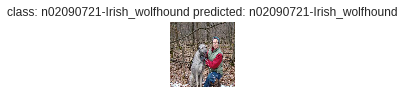

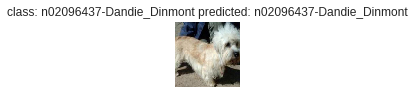

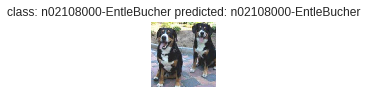

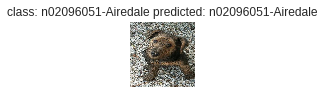

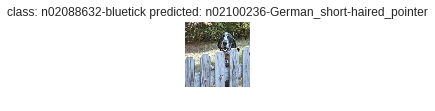

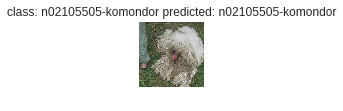

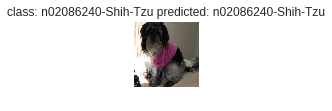

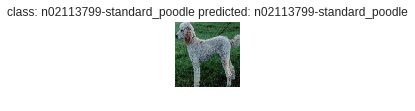

In [10]:
visualize_model(model_ft)

In [0]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [0]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    #with torch.no_grad():
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [0]:
def calc_accuracy(model, data):
    model.eval()
    if use_gpu:
      model.cuda()    
    running_corrects = 0
    test_acc = 0
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    for idx, (inputs, labels) in enumerate(dataloders[data]):
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        # obtain the outputs from the model
        outputs = model.forward(Variable(inputs))
        prec1, prec5 = accuracy(outputs, Variable(labels), topk=(1, 5))
        top1.update(prec1[0], inputs.size(0))
        top5.update(prec5[0], inputs.size(0))
        
    return top1 ,top5
    
top1 ,top5 = calc_accuracy(model_ft, 'Testing')

In [25]:
top1.avg

Variable containing:
 76.6550
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [26]:
top5.avg

Variable containing:
 96.1538
[torch.cuda.FloatTensor of size 1 (GPU 0)]